In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

## Load Data

In [2]:
class1 = pd.read_csv('data/Data_Class_1.csv')
class3 = pd.read_csv('data/Data_Class_3.csv')
class6 = pd.read_csv('data/Data_Class_6.csv')

## Descriptive Statistics

In [3]:
class1.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,7996.077778,3128.025926,159.463426,13.112963,271.507407,41.281481,2579.715741,211.690278,223.248611,144.065741,1994.412963,60.367088,301.612481,657.822412,34.886088
std,4546.422030,156.124988,117.280496,6.817153,221.250993,55.740461,1495.176212,25.399338,17.975428,36.114843,1249.350813,17.352168,87.267254,321.517318,17.363563
min,41.000000,2525.000000,0.000000,1.000000,0.000000,-97.000000,108.000000,86.000000,125.000000,0.000000,30.000000,30.000000,150.070000,90.070000,5.080000
25%,4410.250000,3036.000000,54.000000,8.000000,90.000000,4.000000,1380.000000,199.000000,214.000000,122.000000,1080.250000,45.407500,226.362500,381.892500,19.857500
50%,8986.000000,3144.000000,123.000000,12.000000,218.000000,23.000000,2377.000000,216.000000,226.000000,144.000000,1817.500000,60.340000,305.055000,653.070000,34.460000
75%,10867.750000,3234.000000,286.000000,17.000000,395.000000,61.000000,3601.250000,230.000000,236.000000,169.000000,2642.000000,75.497500,375.057500,938.845000,50.302500
max,14874.000000,3675.000000,359.000000,41.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,246.000000,6993.000000,89.960000,449.740000,1199.660000,64.990000


In [4]:
class3.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,8065.125309,2398.719136,173.564198,20.547531,210.653704,63.698148,964.045062,202.020988,216.605556,141.287654,919.096914,60.085142,297.939926,635.985957,34.885148
std,4048.970637,193.145893,107.745807,8.922400,140.522379,57.553334,622.583347,40.362313,27.412041,51.753036,525.422196,17.276448,86.727560,326.891571,17.685393
min,1819.000000,1903.000000,0.000000,1.000000,0.000000,-103.000000,0.000000,58.000000,120.000000,0.000000,30.000000,30.010000,150.260000,91.390000,5.000000
25%,4582.250000,2270.750000,85.000000,14.000000,95.000000,20.000000,467.000000,174.000000,200.000000,105.000000,529.500000,45.097500,222.472500,344.672500,19.377500
50%,7238.000000,2411.000000,160.000000,20.000000,190.000000,52.000000,891.000000,212.000000,222.000000,142.000000,833.000000,60.205000,294.820000,643.530000,35.155000
75%,11309.250000,2549.000000,276.000000,27.000000,302.250000,96.000000,1308.500000,235.000000,238.000000,181.000000,1203.750000,75.135000,373.467500,923.642500,50.165000
max,15118.000000,2840.000000,360.000000,47.000000,700.000000,275.000000,3181.000000,254.000000,254.000000,248.000000,2812.000000,89.930000,449.790000,1199.880000,64.980000


In [5]:
class6.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,8061.305093,2423.276852,180.617130,18.986111,160.095370,44.873611,1064.980556,193.562963,209.960648,147.682407,1057.654167,59.782051,300.184528,645.943866,35.494847
std,3949.174092,188.966981,133.087862,7.714618,125.770515,47.034674,576.384899,33.684031,23.934851,45.588500,576.691004,17.553901,85.768490,322.144798,17.338936
min,1869.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,127.000000,22.000000,0.000000,30.020000,150.030000,90.900000,5.030000
25%,5275.750000,2319.750000,44.000000,13.000000,60.000000,7.000000,626.000000,169.000000,195.000000,114.000000,643.500000,44.197500,227.582500,365.457500,20.732500
50%,7164.500000,2430.000000,171.000000,19.000000,134.000000,33.000000,993.000000,196.000000,213.000000,150.000000,942.000000,59.590000,302.425000,652.000000,36.005000
75%,11470.500000,2553.000000,318.000000,24.000000,240.000000,73.000000,1420.500000,221.000000,227.000000,184.000000,1364.250000,74.785000,371.582500,923.100000,50.142500
max,15113.000000,2883.000000,360.000000,52.000000,624.000000,249.000000,3078.000000,254.000000,254.000000,238.000000,2918.000000,89.990000,449.970000,1198.460000,64.990000


In [6]:
data = pd.concat([class1, class3, class6], ignore_index=True)
data

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,15106,2480,10,21,150,38,607,193,194,133,1436,82.97,247.13,190.52,45.88,Type_10,Area_3,Type_6
5936,15110,2600,57,19,0,0,731,229,197,93,1332,38.82,163.93,853.03,34.03,Type_10,Area_3,Type_6
5937,15111,2508,33,26,67,1,644,204,173,91,1385,75.93,366.25,442.88,6.98,Type_10,Area_3,Type_6
5938,15112,2610,59,17,60,10,674,231,202,98,1328,74.65,312.00,651.50,55.74,Type_10,Area_3,Type_6


In [7]:
data.describe(include='all')

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940,5940,5940
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,4,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Type_10,Area_3,Type_1
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1634,2529,2160
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199,NaN,NaN,NaN
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532,NaN,NaN,NaN
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000,NaN,NaN,NaN
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000,NaN,NaN,NaN
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000,NaN,NaN,NaN
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000,NaN,NaN,NaN


## Univariate Analysis

In [8]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

In [9]:
data.nunique()

Id                                    5940
Altitude                              1400
Slope_Orientation                      361
Slope                                   46
Horizontal_Distance_To_Water           257
Vertical_Distance_To_Water             322
Horizontal_Distance_To_Roadways       2061
Shadow_Index_9h                        171
Shadow_Index_12h                       128
Shadow_Index_15h                       234
Horizontal_Distance_To_Fire_Points    1741
Canopy_Density                        3787
Rainfall_Summer                       5396
Rainfall_Winter                       5805
Wind_Exposure_Level                   3767
Soil_Type                               32
Wilderness_Area                          4
Vegetation_Type                          3
dtype: int64

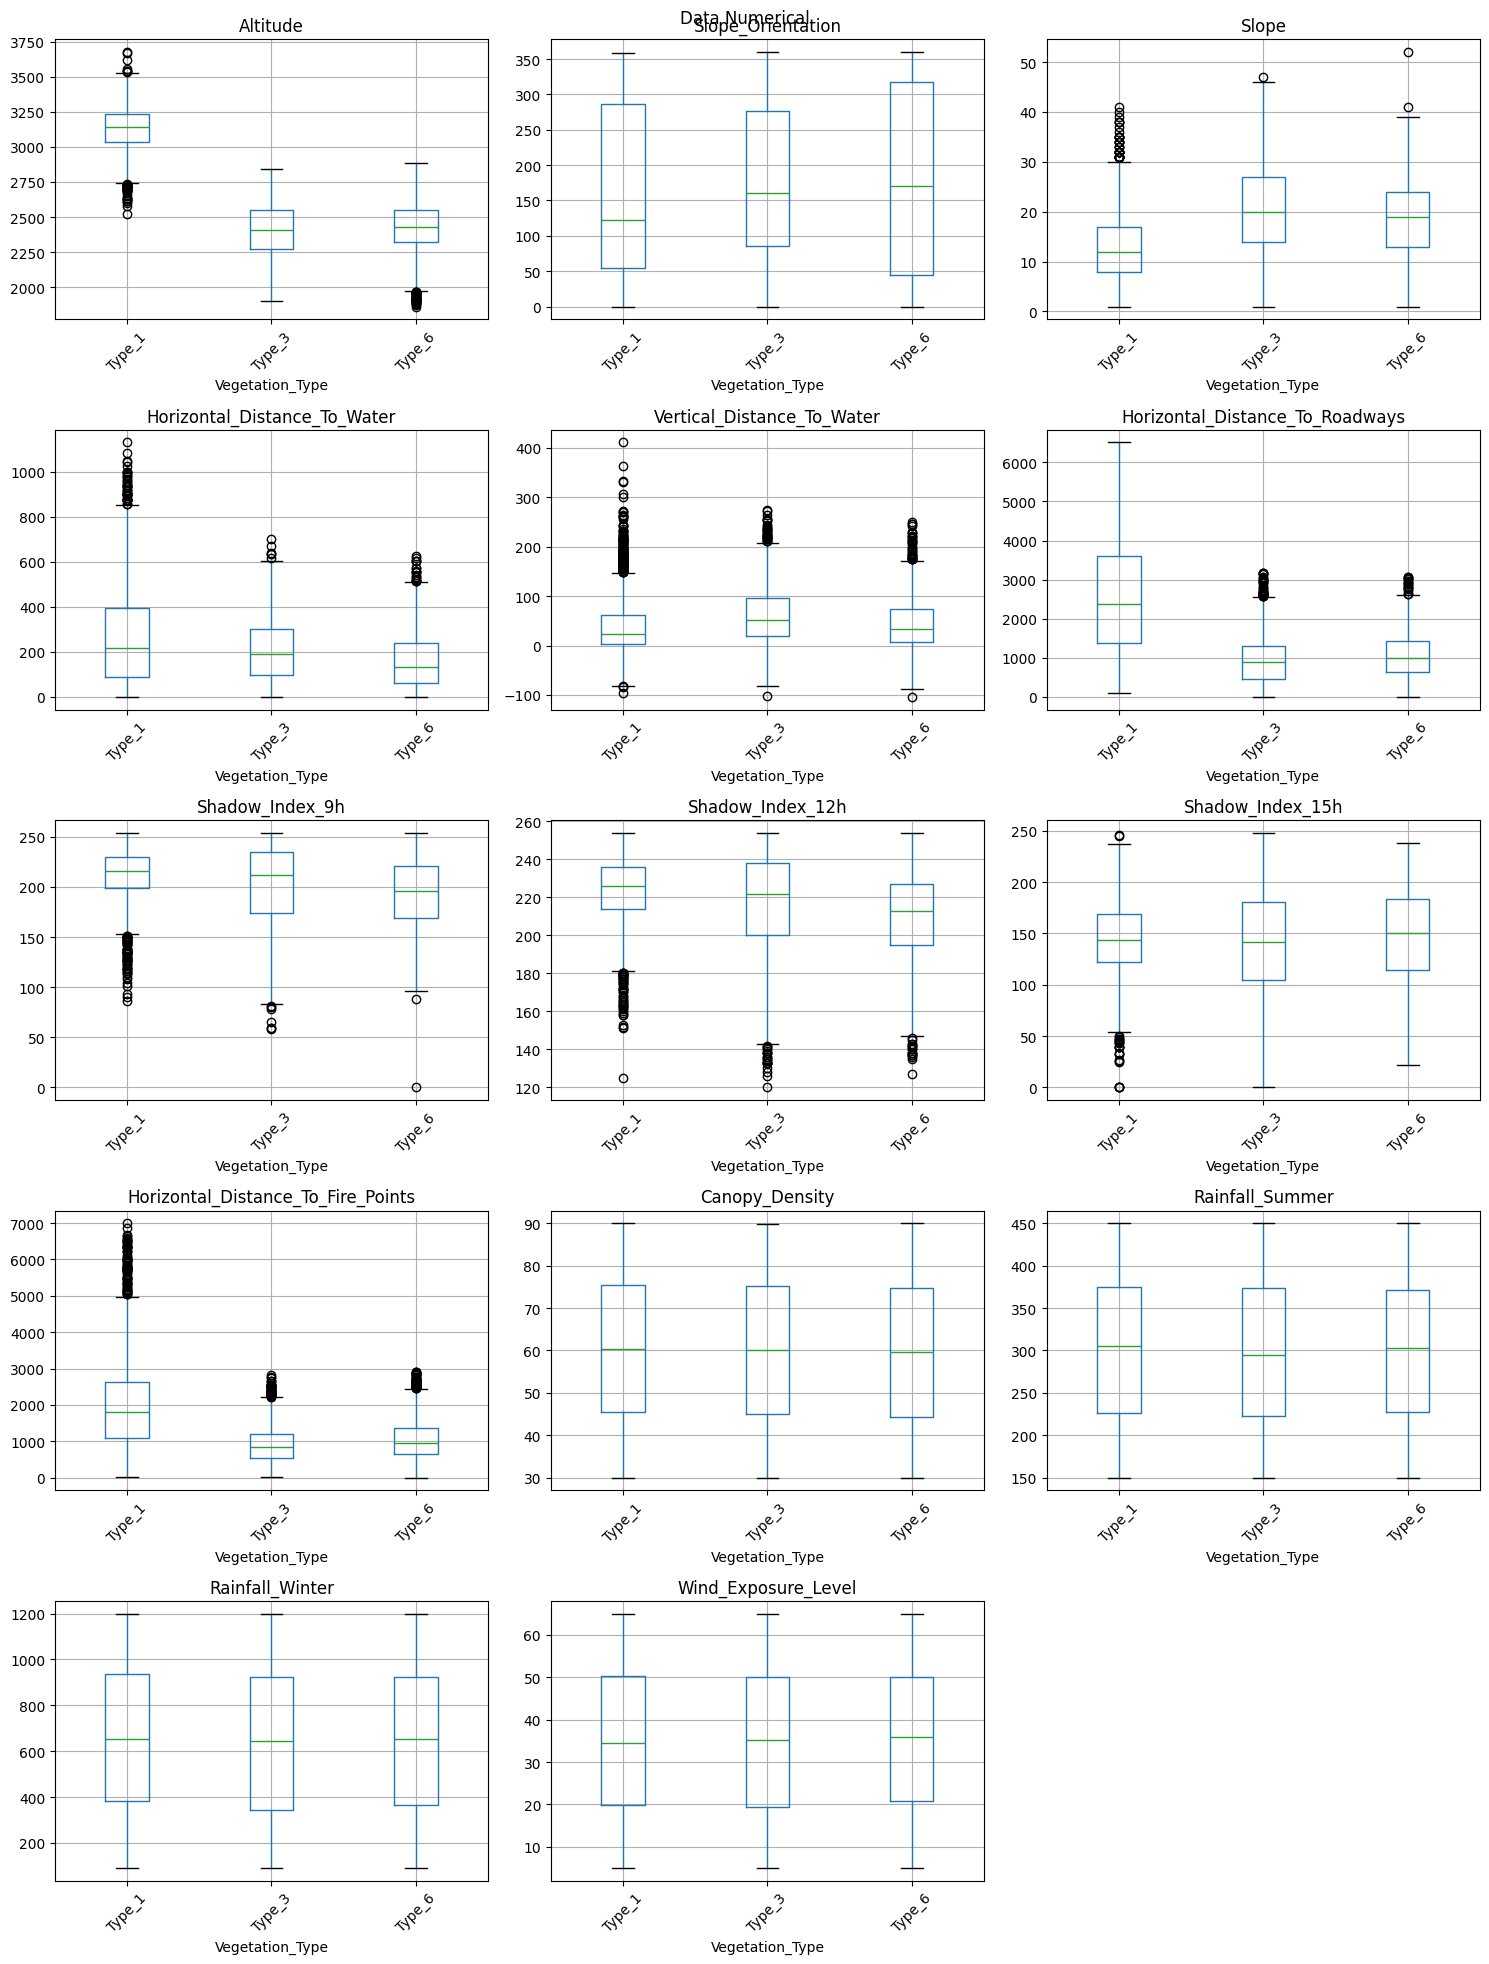

In [10]:
grafic_visualization(data, 'Data Numerical', numerical_columns, 'numerical')

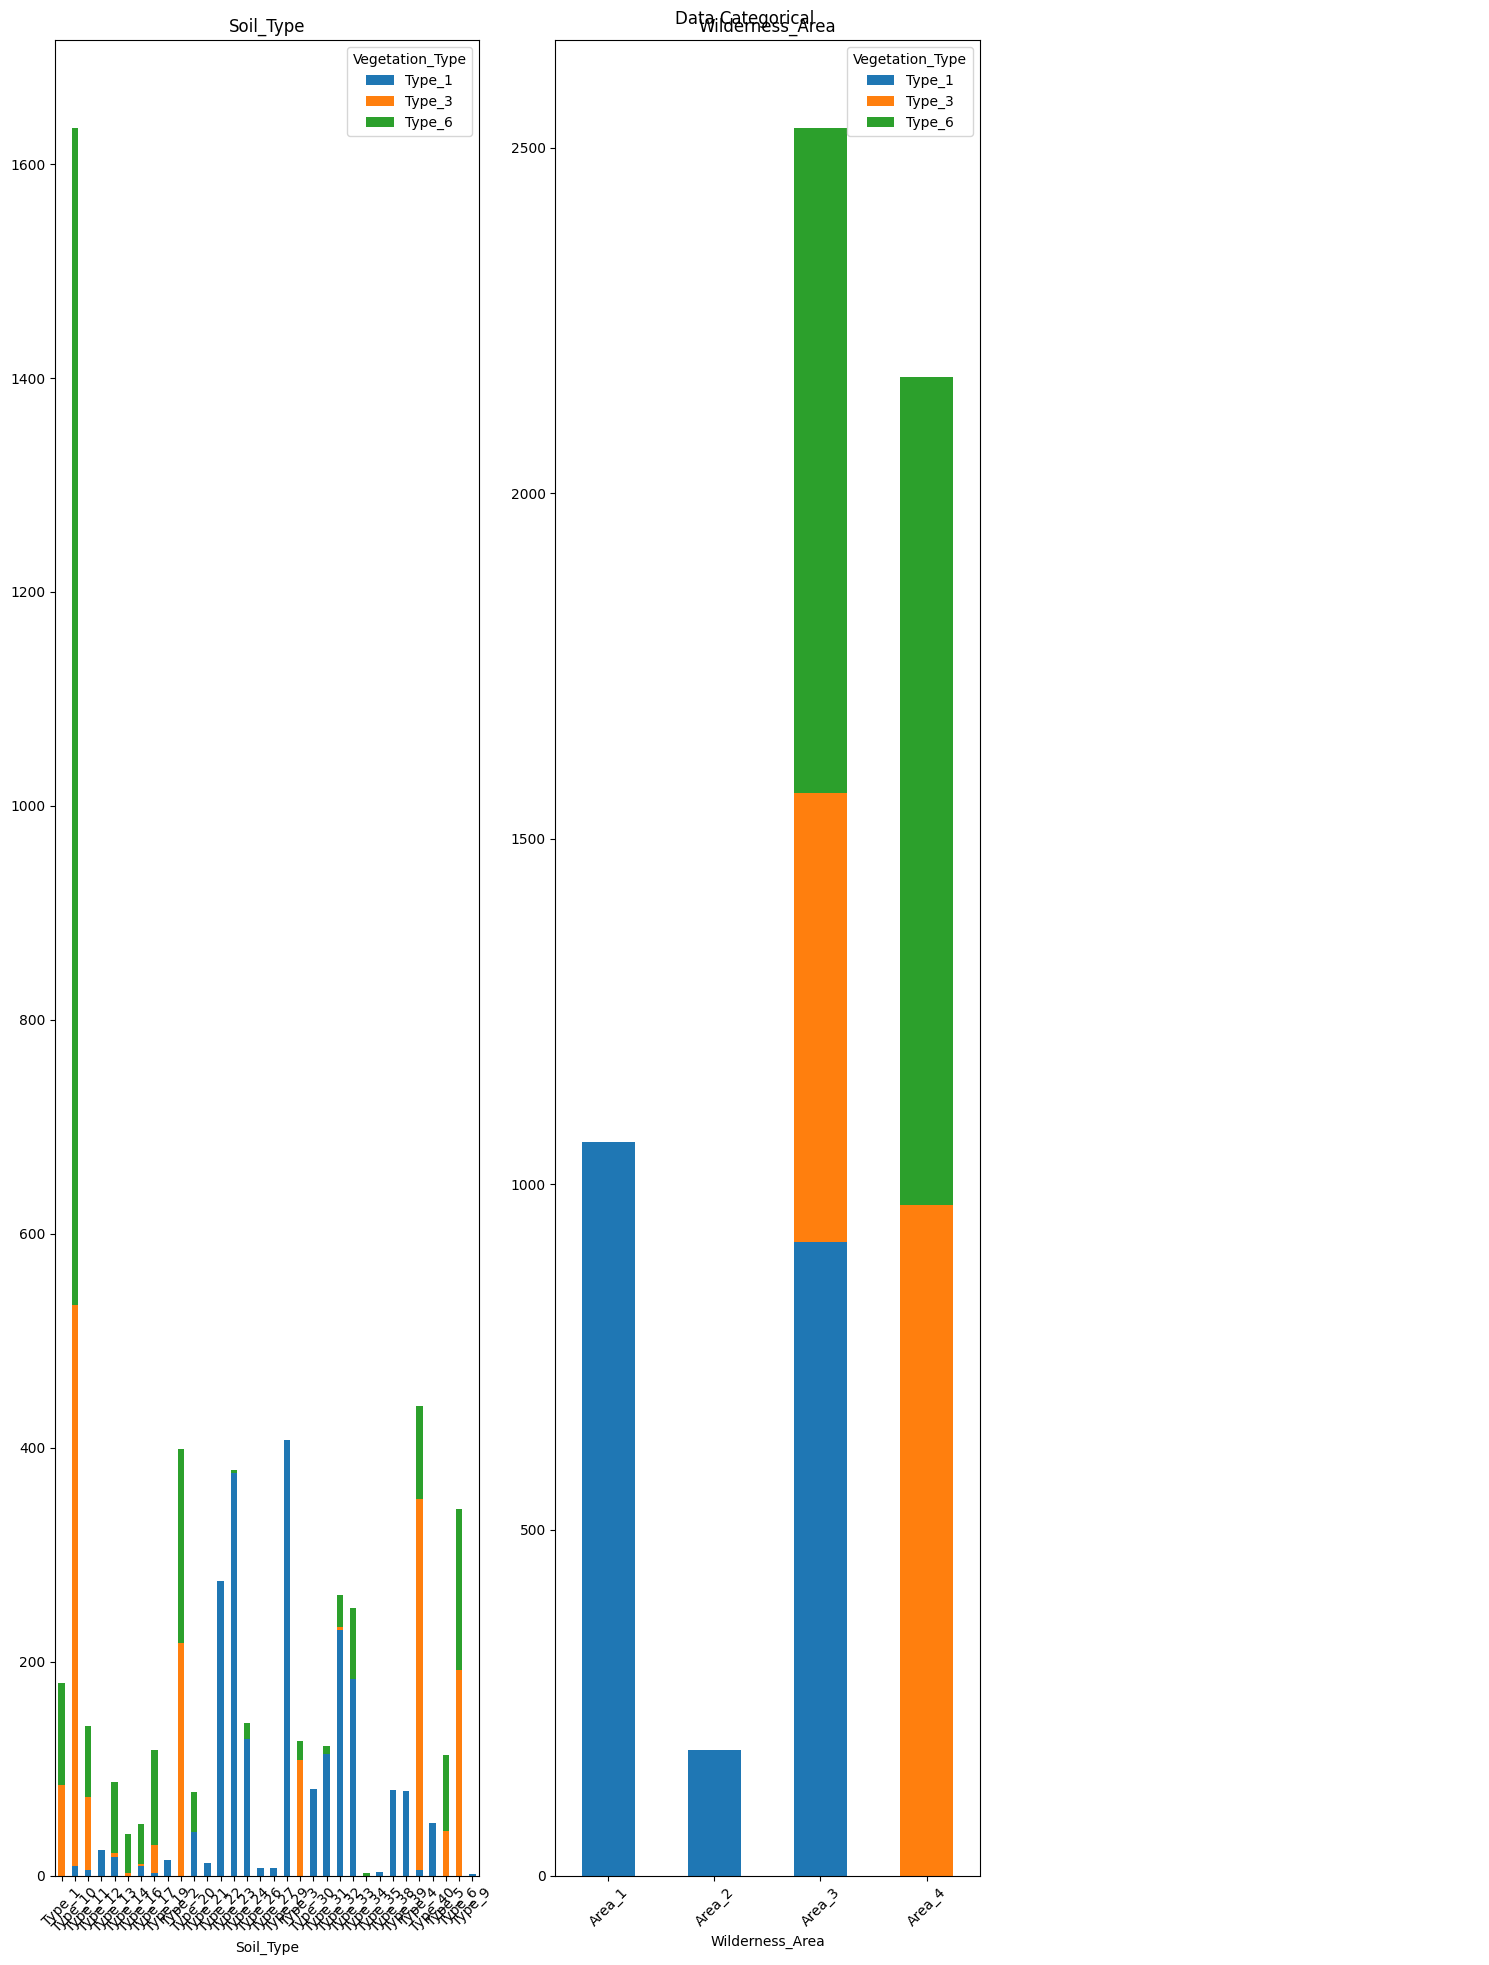

In [11]:
grafic_visualization(data, 'Data Categorical', categorical_columns, 'categorical')